# Farm Pin Crop Detection Challenge

## Background

Resources:

* [Competition page](https://zindi.africa/competitions/farm-pin-crop-detection-challenge)
* [Useful discussion of how to get started](https://zindi.africa/competitions/farm-pin-crop-detection-challenge/discussions/201)
* [fastai notebook on feature detection from satellites](http://localhost:8000/notebooks/fast-ai/course-v3/nbs/dl1/lesson3-planet.ipynb)
* [video on rasterio python lib for sentinal viewing](https://www.youtube.com/watch?v=3kj8uoOlwjg)
* [cmap parameter](https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html#classes-of-colormaps)
* [shapefile format](https://en.wikipedia.org/wiki/Shapefile)

Tutorials:

* [masking by shapefile](https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html)
* [Read cloud-optimized geotiffs](https://automating-gis-processes.github.io/CSC/notebooks/L5/read-cogs.html)

Sentinel 2 Spectral Bands (from [wikipedia](https://en.wikipedia.org/wiki/Sentinel-2))
```
Band 1 – Coastal aerosol
Band 2 – Blue
Band 3 – Green
Band 4 – Red
Band 5 – Vegetation red edge
Band 6 – Vegetation red edge
Band 7 – Vegetation red edge
Band 8 – NIR
Band 8A – Narrow NIR
Band 9 – Water vapour
Band 10 – short wave infrared spectral range (SWIR) – Cirrus
Band 11 – SWIR
Band 12 – SWIR
```

Shapefile info (from [wikipedia](https://en.wikipedia.org/wiki/Shapefile)):
```
MANDATORY FILES
.shp — shape format; the feature geometry itself
.shx — shape index format; a positional index of the feature geometry to allow seeking forwards and backwards quickly
.dbf — attribute format; columnar attributes for each shape, in dBase IV format

OTHER FILES
.prj — projection description, using a well-known text representation of coordinate reference systems
.sbn and .sbx — a spatial index of the features
.fbn and .fbx — a spatial index of the features that are read-only
.ain and .aih — an attribute index of the active fields in a table
.ixs — a geocoding index for read-write datasets
.mxs — a geocoding index for read-write datasets (ODB format)
.atx — an attribute index for the .dbf file in the form of shapefile.columnname.atx (ArcGIS 8 and later)
.shp.xml — geospatial metadata in XML format, such as ISO 19115 or other XML schema
.cpg — used to specify the code page (only for .dbf) for identifying the character encoding to be used
.qix — an alternative quadtree spatial index used by MapServer and GDAL/OGR software
```

## Install and Import Useful Libs

In [ ]:
#!conda install -c conda-forge fiona
#!conda install -c conda-forge rasterio

In [15]:
import fiona
import rasterio
import rasterio.mask
from rasterio import plot as rplt
from fastai import *
from fastai.vision import *
import requests
import os

## Download the Data

In [3]:
def download_zindi_file(competition_slug, file_name, auth_token):

    base_url = "https://api.zindi.africa/v1/competitions/%s/files/" % (competition_slug)
    data_dict = {'auth_token': auth_token}

    # Send HTTP GET request to server and attempt to receive a response
    response = requests.post(url=base_url+file_name, data=data_dict)
 
    # If the HTTP GET request can be served
    if response.status_code == 200:
        
        filepath = "./data/" + file_name
        
        if not os.path.exists(os.path.dirname(filepath)):
            try:
                os.makedirs(os.path.dirname(filepath))
            except OSError as exc: # Guard against race condition
                if exc.errno != errno.EEXIST:
                    raise
 
        # Write the file contents in the response to a file specified by local_file_path
        with open(filepath, 'wb') as local_file:
            for chunk in response.iter_content(chunk_size=128):
                local_file.write(chunk)
            print("%s downloaded to %s!" % (file_name, filepath))

In [4]:
competition_slug = "farm-pin-crop-detection-challenge"
#files = ['OrangeRiver_Climate.docx',
        'Farmpin_training.csv',
        'crop_id_list.csv',
        'test.zip',
        'train.zip',
        'sample_submission_fixed.csv',
        'OrangeRiver_Crop_Growth_Stages.docx',
        '2017-01-01.zip',
        '2017-01-01-JFP.zip']

auth_token = "bXovouvcvEhsPernfMeaxDc2"

In [ ]:
for file in files:
    download_zindi_file(competition_slug, file, auth_token)

In [ ]:
#!unzip data/train.zip
#!unzip data/test.zip
#!unzip data/2017-01-01.zip
#!unzip data/2017-01-01-JFP.zip
#!rm data/train.zip
#!rm data/test.zip
#!rm data/2017-01-01.zip
#!rm data/2017-01-01-JFP.zip

## Explore the Data

In [3]:
data_path = Path('./data')
data_path.ls()

[PosixPath('data/Farmpin_training.csv'),
 PosixPath('data/S2A_MSIL1C_20170101T082332_N0204_R121_T34JFP_20170101T084543.SAFE'),
 PosixPath('data/sample_submission_fixed.csv'),
 PosixPath('data/crop_id_list.csv'),
 PosixPath('data/train'),
 PosixPath('data/test'),
 PosixPath('data/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE'),
 PosixPath('data/OrangeRiver_Climate.docx'),
 PosixPath('data/OrangeRiver_Crop_Growth_Stages.docx')]

In [4]:
Path(data_path/'train').ls()

[PosixPath('data/train/train.dbf'),
 PosixPath('data/train/train.shp'),
 PosixPath('data/train/train.shx'),
 PosixPath('data/train/train.prj'),
 PosixPath('data/train/train.cpg'),
 PosixPath('data/train/train.qpj')]

In [5]:
Path(data_path/'test').ls()

[PosixPath('data/test/test.shp'),
 PosixPath('data/test/test.shx'),
 PosixPath('data/test/test.cpg'),
 PosixPath('data/test/test.dbf'),
 PosixPath('data/test/test.qpj'),
 PosixPath('data/test/test.prj')]

In [6]:
crop_labels_df = pd.read_csv(data_path/'Farmpin_training.csv')
crop_labels_df.head(3)

,field_id,crop_id
0,1,8
1,2,6
2,3,8


In [7]:
crop_labels_human_df = pd.read_csv(data_path/'crop_id_list.csv')
crop_labels_human_df.head(3)

,crop_id,crop
0,1,Cotton
1,2,Dates
2,3,Grass


## Prepare the Raster Data

In [125]:
img_path = data_path/'S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE'/'GRANULE'/'L1C_T34JEP_A007983_20170101T084543'/'IMG_DATA'
img_path_jfp = data_path/'S2A_MSIL1C_20170101T082332_N0204_R121_T34JFP_20170101T084543.SAFE'/'GRANULE'/'L1C_T34JFP_A007983_20170101T084543'/'IMG_DATA'

### Optionally Convert to TIF to view using matplotlib
(later found this is not necessary)

In [86]:
from osgeo import gdal
driver = gdal.GetDriverByName("GTiff")
for img_file_in in img_path.ls():
    in_image = gdal.Open(img_file_in.as_posix())
    img_file_out = "%s/%s.%s" % (img_path, img_file_in.stem, 'tif')
    out_image = driver.CreateCopy(img_file_out, in_image, 0)

in_image = None
out_image = None

TypeError: Invalid shape (3, 10980, 10980) for image data

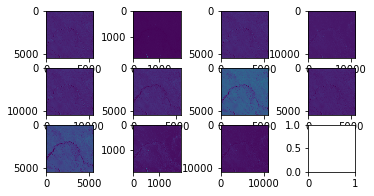

In [102]:
fig=plt.figure()
num_img = len(img_path.ls())/2
i = 1
for img_file in img_path.ls():
    if img_file.suffix == ".tif":
        img = gdal.Open(img_file.as_posix())
        img_data = img.ReadAsArray()
        fig.add_subplot(num_img//3, 4, i)
        plt.imshow(img_data)
        i = i+1
    img = None

### Load directly from JP2 using rasterio

In [9]:
band1  = rasterio.open(img_path/'T34JEP_20170101T082332_B01.jp2', driver='JP2OpenJPEG')
band2  = rasterio.open(img_path/'T34JEP_20170101T082332_B02.jp2', driver='JP2OpenJPEG') # blue
band3  = rasterio.open(img_path/'T34JEP_20170101T082332_B03.jp2', driver='JP2OpenJPEG') # green
band4  = rasterio.open(img_path/'T34JEP_20170101T082332_B04.jp2', driver='JP2OpenJPEG') # red
band5  = rasterio.open(img_path/'T34JEP_20170101T082332_B05.jp2', driver='JP2OpenJPEG') # nir
band6  = rasterio.open(img_path/'T34JEP_20170101T082332_B06.jp2', driver='JP2OpenJPEG')
band7  = rasterio.open(img_path/'T34JEP_20170101T082332_B07.jp2', driver='JP2OpenJPEG')
band8  = rasterio.open(img_path/'T34JEP_20170101T082332_B08.jp2', driver='JP2OpenJPEG')
band8a = rasterio.open(img_path/'T34JEP_20170101T082332_B8A.jp2', driver='JP2OpenJPEG')
band9  = rasterio.open(img_path/'T34JEP_20170101T082332_B09.jp2', driver='JP2OpenJPEG')
band10 = rasterio.open(img_path/'T34JEP_20170101T082332_B10.jp2', driver='JP2OpenJPEG')
band11 = rasterio.open(img_path/'T34JEP_20170101T082332_B11.jp2', driver='JP2OpenJPEG')
band12 = rasterio.open(img_path/'T34JEP_20170101T082332_B12.jp2', driver='JP2OpenJPEG')

band3.shape

(10980, 10980)

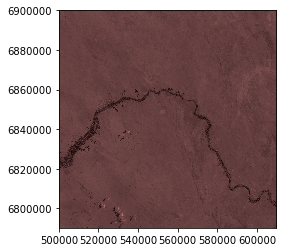

In [128]:
rplt.show(band4, cmap='pink')

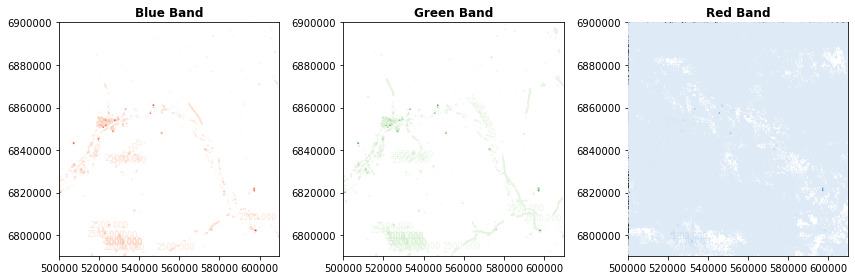

In [136]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
rplt.show(band2, ax=ax1, cmap='Reds', contour=True, title="Blue Band")
rplt.show(band3, ax=ax2, cmap="Greens", contour=True, title="Green Band")
rplt.show(band4, ax=ax3, cmap="Blues", contour=True, title="Red Band")
fig.tight_layout()

In [114]:
trueColor = rasterio.open(img_path/'SentinalTrueColor.tiff', 'w', driver="Gtiff",
                         width=band4.width, height=band4.height,
                         count=3,
                         crs=band4.crs,
                         transform=band4.transform,
                         dtype=band4.dtypes[0]
                         )
trueColor.write(band2.read(1),3) #blue
trueColor.write(band3.read(1),2) #green
trueColor.write(band4.read(1),1) #red
trueColor.close()

In [14]:
tc_tiff_path = img_path/'SentinalTrueColor.tiff'
src = rasterio.open(tc_tiff_path, count=3)
rplt.show(src, title="True Color (RGB) TIFF representation")

NameError: name 'rplt' is not defined

<IPython.core.display.Javascript object>


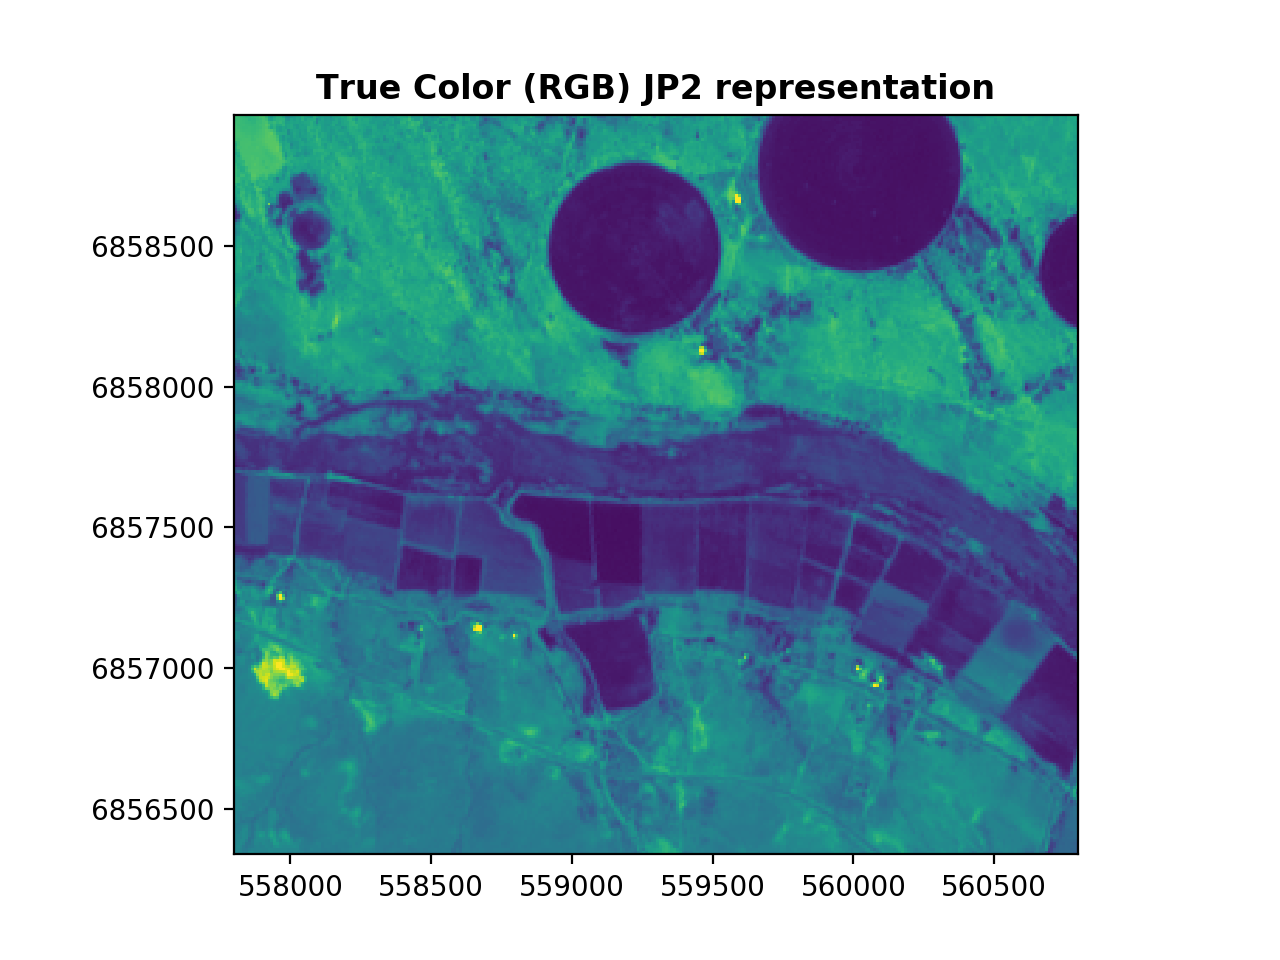

In [94]:
%matplotlib notebook
src = rasterio.open(img_path/'T34JEP_20170101T082332_TCI.jp2', driver='JP2OpenJPEG')
rplt.show(src, title="True Color (RGB) JP2 representation")

## Prepare the Shape Data for Masking

In [33]:
train_shp_path = data_path/'train'/'train.shp'

with fiona.open(train_shp_path, "r") as shapefile:
    features = [feature for feature in shapefile if feature['geometry']] # three items with 'geometry': None

In [58]:
features[0]

{'type': 'Feature',
 'id': '0',
 'properties': OrderedDict([('Field_Id', 1),
              ('Area', 0.915905),
              ('Subregion', 3),
              ('Crop_Id_Ne', '8')]),
 'geometry': {'type': 'Polygon',
  'coordinates': [[(2467881.1750413314, -3352032.0592964217),
    (2468026.166997987, -3352002.1613220456),
    (2468030.9295075075, -3352046.3468240052),
    (2467906.045924405, -3352113.021952709),
    (2467881.1750413314, -3352032.0592964217)]]}}

<IPython.core.display.Javascript object>


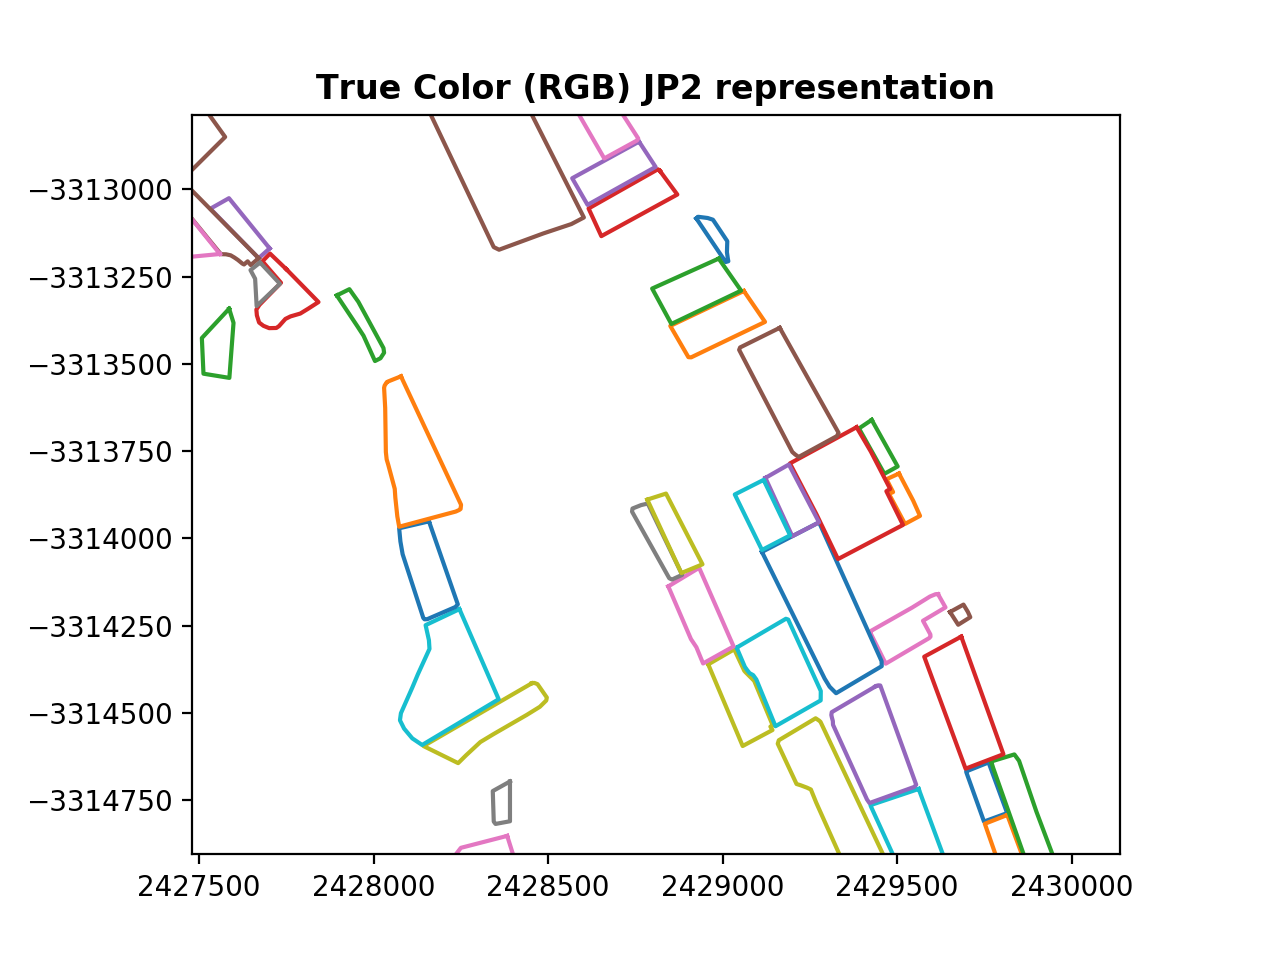

X bounds: (2378321.9724794813, 2468711.8342985143), Y bounds: (-3352784.2075977274, -3277536.9361150875)


In [92]:
%matplotlib notebook

def plot_coords(coords):
    x = [i[0] for i in coords]
    y = [i[1] for i in coords]
    plt.plot(x,y)

plt.figure()
for f in features:
    if f['geometry']['type'] == 'MultiPolygon':
        for coord in f['geometry']['coordinates'][0][:]:
            plot_coords(coord)
    else:
        plot_coords(f['geometry']['coordinates'][0][:])
plt.show()

print("X bounds: %s, Y bounds: %s" % (x_range, y_range))

## Harmonize Projections of Shape and Raster Files

### Check projections

In [97]:
band2.crs # blue raster crs

CRS.from_epsg(32734)

In [114]:
train_prj_path = data_path/'train'/'train.prj'
!cat {train_shp_path}

PROJCS["Mercator_2SP",GEOGCS["GCS_WGS_1984",DATUM["D_unknown",SPHEROID["WGS84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Mercator"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1]]

The raster image is [EPSG 32734](https://spatialreference.org/ref/epsg/wgs-84-utm-zone-34s/), while the bounding boxes are [EPSG 9805](http://geotiff.maptools.org/proj_list/mercator_2sp.html) (aka mercator_2sp, as referenced in [train.prj](http://localhost:8000/edit/zindi/farm-pin-crop-detection/data/train/train.prj))

Possible solutions follow. Based on some light reading, of the two options it seems the raster option may be preferred, because they're less sensitive in terms of maginfying small rounding errors, as compared to vector shapes that are defined by only a few points:
* Reproject raster: https://rasterio.readthedocs.io/en/stable/topics/reproject.html
* Reproject vector: https://www.earthdatascience.org/courses/earth-analytics-python/spatial-data-vector-shapefiles/reproject-vector-data-in-python/

### Update raster projections

#### Transform JEP First

In [120]:
from rasterio.warp import calculate_default_transform, reproject, Resampling
from fiona import crs

dst_crs = fiona.open(train_shp_path, "r").crs

with rasterio.open(img_path/'T34JEP_20170101T082332_B02.jp2', driver='JP2OpenJPEG') as src: # band2
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(img_path/'T34JEP_20170101T082332_B02.epsg9805.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

#### Tranform JFP

In [127]:
with rasterio.open(img_path_jfp/'T34JFP_20170101T082332_B02.jp2', driver='JP2OpenJPEG') as src: # band2
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(img_path_jfp/'T34JFP_20170101T082332_B02.epsg9805.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

#### Visually validate Tranformed JEP and JFP Together

<IPython.core.display.Javascript object>


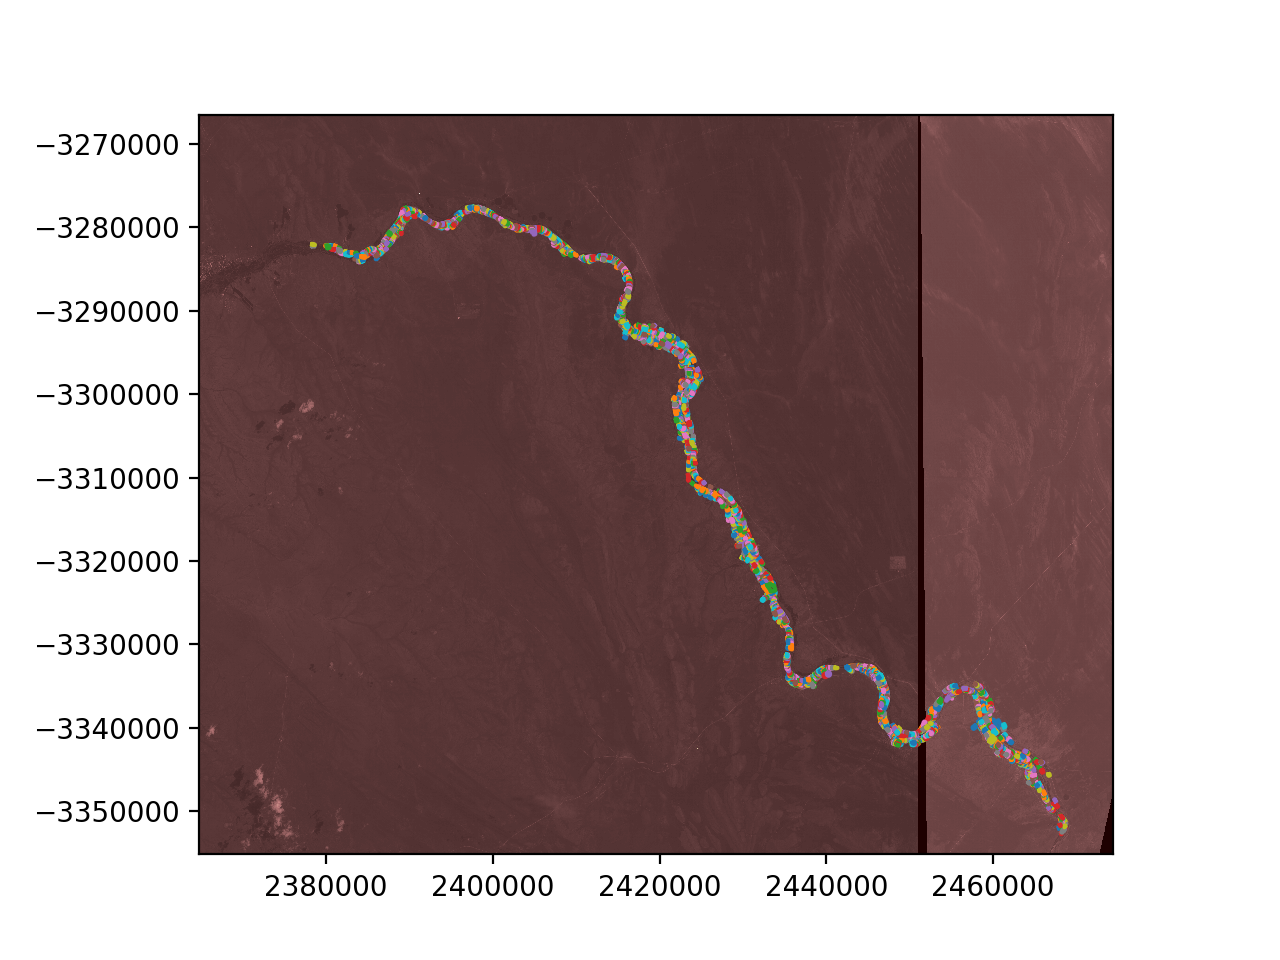

In [129]:
plt.figure()

# Plot vectors shapes
for f in features:
    if f['geometry']['type'] == 'MultiPolygon':
        for coord in f['geometry']['coordinates'][0][:]:
            plot_coords(coord)
    else:
        plot_coords(f['geometry']['coordinates'][0][:])

# Plot JEP raster
with rasterio.open(img_path/'T34JEP_20170101T082332_B02.epsg9805.jp2', driver='JP2OpenJPEG') as img:
    rplt.show(img, cmap="pink")

# Plot JFP raster
with rasterio.open(img_path_jfp/'T34JFP_20170101T082332_B02.epsg9805.jp2', driver='JP2OpenJPEG') as img:
    rplt.show(img, cmap="pink")
    
plt.show()

### Update vector projections

Looks like the raster transformations left a gap between the tiles, so perhaps it's better in this case to leave the images alone and transform the shapes instead. Let's give it a try.

<IPython.core.display.Javascript object>


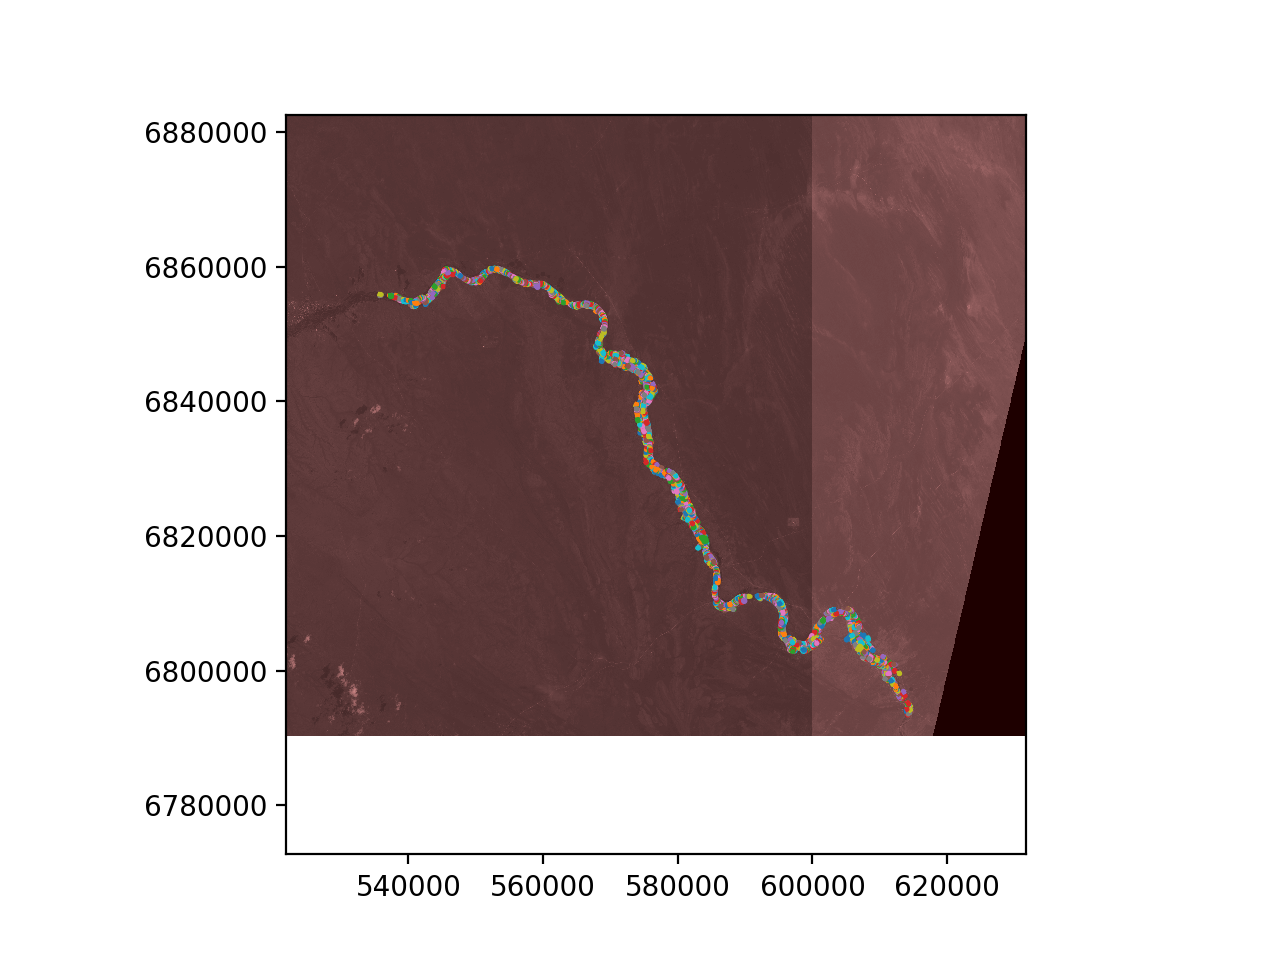

In [151]:
from pyproj import Proj, transform

shp = fiona.open(train_shp_path, "r")
original = Proj(shp.crs)
destination = Proj(band2.crs)

def plot_transformed_coords(coords):
    x = [i[0] for i in coords]
    y = [i[1] for i in coords]
    x, y = transform(original, destination,x,y)
    plt.plot(x, y)

plt.figure()

# Plot vectors shapes
for f in shp:
    if f['geometry']: # 3 without geometry
        if f['geometry']['type'] == 'MultiPolygon':
            for coord in f['geometry']['coordinates'][0][:]:
                plot_transformed_coords(coord)
        else:
            plot_transformed_coords(f['geometry']['coordinates'][0][:])

# Plot JEP raster
with rasterio.open(img_path/'T34JEP_20170101T082332_B02.jp2', driver='JP2OpenJPEG') as img:
    rplt.show(img, cmap="pink")

# Plot JFP raster
with rasterio.open(img_path_jfp/'T34JFP_20170101T082332_B02.jp2', driver='JP2OpenJPEG') as img:
    rplt.show(img, cmap="pink")
    
plt.show()

## Crop the images (into labeled fields) using the shapes as masks

### Discard Masks that are outside raster bounds

In [98]:
# Test to see if features are all inside of src (warning will come up rather than error because crop is False)
with rasterio.open(tc_tiff_path, driver="Gtiff") as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=False)
del out_image
del out_transform

/home/matt/anaconda3/lib/python3.7/site-packages/rasterio/mask.py:89: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


### Execute the masking

In [ ]:
with rasterio.open(tc_tiff_path, driver="Gtiff") as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_meta = src.meta.copy()

    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

    with rasterio.open("RGB.byte.masked.tif", "w", **out_meta) as dest:
        dest.write(out_image)
        